<a href="https://colab.research.google.com/github/vineetsalar88/ResrachPaper2/blob/master/18Dec25Obj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
# 1️⃣ Load CSV
# -------------------------------
csv_path = "/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotations.csv"
image_folder = "/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images"   # folder containing your image files

df = pd.read_csv(csv_path)

# Add full image paths
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_folder, x))
pd.set_option('display.max_colwidth', None)
print(df['image_path'].head(10))





0    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/001.jpg
1    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/002.jpg
2    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/003.jpg
3    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/004.jpg
4    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/004.jpg
5    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/005.jpg
6    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/006.jpg
7    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/007.jpg
8    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/008.jpg
9    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/008.jpg
Name: image_path, dtype: object


In [19]:
from PIL import Image
import os

broken_images = []

for path in df['image_path']:
    try:
        img = Image.open(path)
        img.verify()  # verify doesn't load the whole image, just checks integrity
    except Exception as e:
        broken_images.append((path, str(e)))

print(f"Found {len(broken_images)} broken images.")
for b in broken_images[:10]:
    print(b)


Found 0 broken images.


In [4]:
df.dropna(subset=['label'], inplace=True)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [7]:
#Create ImageDataGenerators -------------------------------
from PIL import Image
import os
img_size = (128, 128)
batch_size = 32

# Filter out rows with invalid image paths
train_df = train_df[train_df['image_path'].apply(lambda x: os.path.exists(x))]
val_df = val_df[val_df['image_path'].apply(lambda x: os.path.exists(x))]

# Add a robust check for image loading and resizing issues
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize(img_size) # Try resizing to trigger potential errors
        img.verify()
        return True
    except Exception as e:
        print(f"Could not load or process image {image_path}: {e}")
        return False

# Filter dataframes based on image loadability
train_df_cleaned = train_df[train_df['image_path'].apply(is_image_loadable)]
val_df_cleaned = val_df[val_df['image_path'].apply(is_image_loadable)]

print(f"Original train_df size: {len(train_df)}, Cleaned train_df size: {len(train_df_cleaned)}")
print(f"Original val_df size: {len(val_df)}, Cleaned val_df size: {len(val_df_cleaned)}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Original train_df size: 552, Cleaned train_df size: 552
Original val_df size: 138, Cleaned val_df size: 138
Found 552 validated image filenames belonging to 8 classes.
Found 138 validated image filenames belonging to 8 classes.


In [8]:
# Make sure to run the cell above this one (cell `0zqEiKczWeK6`) to define `img_size`, `train_gen`, and `val_gen` first.
# 4️⃣ Build CNN Model
# -------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.2635 - loss: 1.9003 - val_accuracy: 0.3043 - val_loss: 1.7219
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.2678 - loss: 1.7890 - val_accuracy: 0.3043 - val_loss: 1.7209
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.3317 - loss: 1.7335 - val_accuracy: 0.3116 - val_loss: 1.7113
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.2919 - loss: 1.7273 - val_accuracy: 0.3261 - val_loss: 1.7090
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.2930 - loss: 1.7274 - val_accuracy: 0.3406 - val_loss: 1.6252
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.3622 - loss: 1.5588


✅ Validation Accuracy: 34.06%


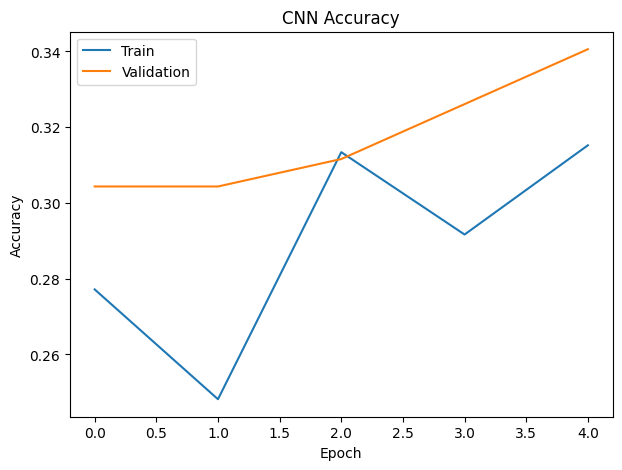

In [9]:
# Make sure to run the cell above this one to define and compile the model first.
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# ============================================
# ❓ 9⏹  Evaluate and Save
# ============================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")

model.save("cnn_multiclass_bbox_model.h5")

# ============================================
# ❓ ⟹⏹  Optional: Plot Accuracy
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
Number of classes: 8
Class names: ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5', 'Score 6', 'Score 7', 'Score 8']
Confusion Matrix:
 [[ 0  0  0  2  0  0  0  0]
 [ 0  0  0  8  0  0  0  0]
 [ 0  0  0 27  0  0  0  0]
 [ 0  0  0 35  7  0  0  0]
 [ 0  0  0 25 12  0  0  0]
 [ 0  0  0  3 10  0  0  0]
 [ 0  0  0  2  4  0  0  0]
 [ 0  0  0  1  2  0  0  0]]


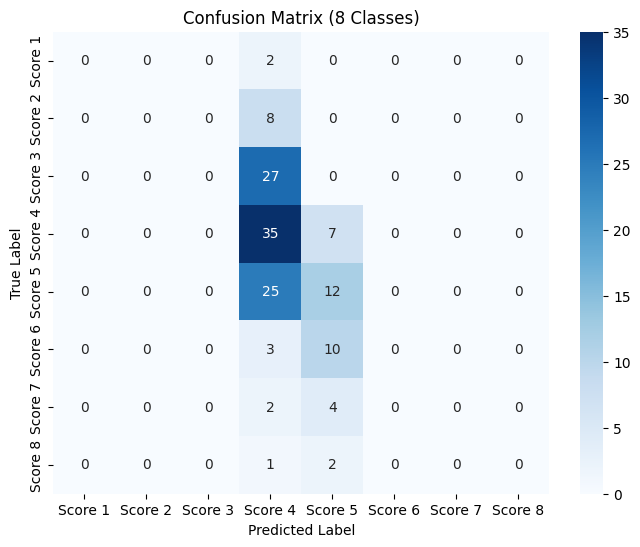

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = val_gen.classes          # numeric class labels (0–7)
class_names = list(val_gen.class_indices.keys())

# Predict probabilities
y_pred_prob = model.predict(val_gen)

# Convert probabilities → predicted class index
y_pred = np.argmax(y_pred_prob, axis=1)

print("Number of classes:", len(class_names))
print("Class names:", class_names)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (8 Classes)")
plt.show()


